## Convolutional Neural Network (CNN) Model for Facial Expression Recognition 
Baseline Model using our own dataset

Facial Expressions: 
- Angry
- Fear
- Happy
- Neutral
- Sad
- Surprised


Directory Structure: 

/data
    /train
        /happy
            - image1.jpg
            - image2.jpg
            ...
        /sad
            - image1.jpg
            - image2.jpg
            ...
        ...
    /validation
        /happy
            - image1.jpg
            - image2.jpg
            ...
        /sad
            - image1.jpg
            - image2.jpg
            ...
        ...
        
        

In [1]:
# import system libs 
import os
import time
import glob
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import load_img, img_to_array

#import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-04-16 03:06:49.810637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/saxyrinchen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


modules loaded


In [ ]:
# import os
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import load_img

# # Path to your original dataset
# dataset_dir = '../data/Processed'

# num_images_per_class = 2

# fig, axes = plt.subplots(nrows=len(os.listdir(dataset_dir)), ncols=num_images_per_class, figsize=(num_images_per_class*4, 20))
# for i, class_name in enumerate(os.listdir(dataset_dir)):
#     class_dir = os.path.join(dataset_dir, class_name)
#     if not os.path.isdir(class_dir):
#         continue  # Skip any files, process only directories
#     images = os.listdir(class_dir)[:num_images_per_class]  # Get the first few images of the class
#     for j, image_name in enumerate(images):
#         img_path = os.path.join(class_dir, image_name)
#         if os.path.isfile(img_path):  # Ensure it's a file, skip otherwise
#             img = load_img(img_path, target_size=(128, 128))  # Load and resize image for consistent display
#             ax = axes[i, j] if len(os.listdir(dataset_dir)) > 1 else axes[j]
#             ax.imshow(img)
#             ax.set_title(class_name)
#             ax.axis('off')
# plt.tight_layout()
# plt.show()


## 2. Data Preprocessing 
#### 2.1 Resize Webcam Images
CNNs require input images to be of the same size. Hence, all our webcam images (regardless of training or testing data) will be resized to 128x128 pixels, maintaining the aspect ratio to avoid distorting facial features. 

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the base directory of your dataset and where the split datasets should reside
base_dataset_dir = 'Dataset'  # Your base dataset directory
train_dir = os.path.join(base_dataset_dir, 'Train')  # Training directory
val_dir = os.path.join(base_dataset_dir, 'Validation')  # Validation directory

# Create the train and validation base directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Set the split ratio for the validation set
validation_ratio = 0.2

# Get all class subdirectories in the base dataset directory
classes = [d for d in os.listdir(base_dataset_dir) if os.path.isdir(os.path.join(base_dataset_dir, d))]

# Loop through each class subdirectory
for class_name in classes:
    class_dir = os.path.join(base_dataset_dir, class_name)
    
    # Skip the train and val directories if they're inside the base_dataset_dir
    if class_dir in (train_dir, val_dir):
        continue

    # Create new class subdirectories in the train and validation directories
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Get a list of all the images in the current class directory
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split the images into training and validation sets
    train_images, val_images = train_test_split(images, test_size=validation_ratio, random_state=42)

    # Move the images to the new training and validation class subdirectories
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_class_dir, img))

print('Dataset split into training and validation sets')


Dataset split into training and validation sets


#### 2.3 Data Augmentation for Training Set
Since we are dealing with a small dataset, we will be implementing data augmentation techniques to increase the size our training dataset ONLY.

Data Augmentation techniques used:
- Flip
- Rotation
- Zoom
- Light Conditions

TRY MORE

In [4]:
# Initialize the training data generator with augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,  # rotations between -15 and +15 degrees
#     width_shift_range=0.1,  # shifts up to 10% of the image width
#     height_shift_range=0.1,  # shifts up to 10% of the image height
#     shear_range=0.1,  # shear intensity (shear angle in degrees)
#     zoom_range=0.1,  # zoom in or out by 10%
#     horizontal_flip=True,  # allow horizontal flipping
#     brightness_range=[0.8, 1.2],  # allow brightness changes by +/- 20%
#     fill_mode='nearest'  # use nearest neighbour filling for new pixels
# )

# try more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  #  rotations
    width_shift_range=0.05,  #  shifts
    height_shift_range=0.05,  #  shifts
    shear_range=0.05,  #  shear
    zoom_range=0.05,  #  zoom
    horizontal_flip=True,  #  horizontal flipping
    brightness_range=[0.75, 1.25],  #  larger brightness variation
    fill_mode='nearest'  # Nearest fill for rotations and shifts
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '../data/Processed/Train'
#  128x128 image size and batch size of 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
val_dir = '../data/Processed/Validation'
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# save into train dataset


Found 804 images belonging to 6 classes.
Found 219 images belonging to 6 classes.


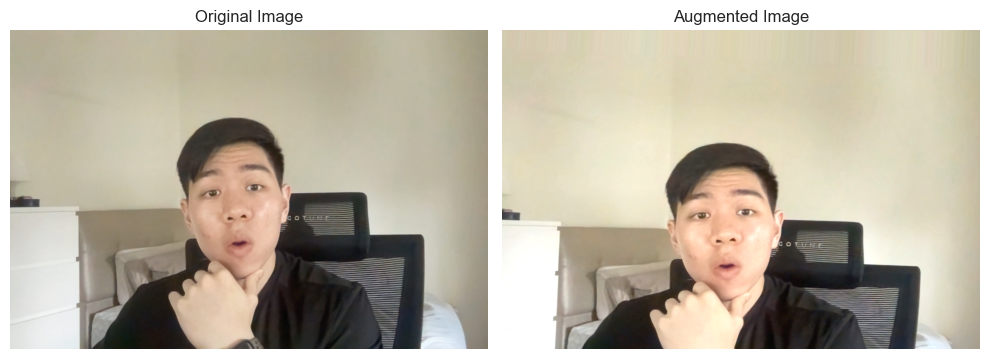

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def create_augmented_image(image_data_generator, image_path):
    # Load the image file into a PIL image
    img = load_img(image_path)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension

    # Generates augmented images
    it = image_data_generator.flow(img_array, batch_size=1)
    augmented_image = next(it)[0]  # Get the first image in the batch

    # Rescale back to [0,255] and convert to uint8
    augmented_image = (augmented_image * 255).astype('uint8')
    
    return augmented_image
# Specify the path to an original image
original_image_path = 'Dataset/Train/Surprise/daniel_2.jpg'

# Load the original image and convert it to an array
original_image = load_img(original_image_path)
original_image = img_to_array(original_image).astype('uint8')

# Generate an augmented image
augmented_image = create_augmented_image(train_datagen, original_image_path)

# Display the original and augmented images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(augmented_image)
ax[1].set_title('Augmented Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()

## CNN Model Building

In [5]:
no_of_classes = 6

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# can try use tanh activation instead of relu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 11,688,326 (44.59 MB)

 Trainable params: 11,684,358 (44.57 MB)

 Non-trainable params: 3,968 (15.50 KB)

## Fitting CNN Model on Training and Validation Data

try cropping out face then model

In [6]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "./model.keras",  # Use '.keras' extension instead of '.h5'
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [early_stopping, checkpoint]

epochs = 48

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [7]:
history = model.fit(
    x=train_generator,  # Pass the generator directly to the 'x' argument
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,  # Pass the generator directly to the 'validation_data' argument
    validation_steps=validation_generator.samples//validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/48
25/25 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.1780 - loss: 2.3372 - val_accuracy: 0.1979 - val_loss: 2.2143
Epoch 2/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.2500 - loss: 2.2450

2024-04-16 03:11:47.833583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2500 - loss: 1.1674 - val_accuracy: 0.1852 - val_loss: 1.0878
Epoch 3/48


2024-04-16 03:11:48.444813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.2149 - loss: 2.0225 - val_accuracy: 0.1667 - val_loss: 1.8218
Epoch 4/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.1875 - loss: 1.9069

2024-04-16 03:13:40.880070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1875 - loss: 0.9916 - val_accuracy: 0.1481 - val_loss: 0.9251
Epoch 5/48


2024-04-16 03:13:41.547341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.2064 - loss: 1.9561 - val_accuracy: 0.1771 - val_loss: 1.9773
Epoch 6/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.0938 - loss: 2.1386

2024-04-16 03:15:28.379460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.0938 - loss: 1.1121 - val_accuracy: 0.0741 - val_loss: 1.1001
Epoch 7/48


2024-04-16 03:15:28.983580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.2020 - loss: 1.9346 - val_accuracy: 0.1562 - val_loss: 1.8216
Epoch 8/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:15 3s/step - accuracy: 0.3438 - loss: 1.7283

2024-04-16 03:17:17.679711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3438 - loss: 0.8987 - val_accuracy: 0.0741 - val_loss: 0.9190
Epoch 9/48


2024-04-16 03:17:18.240675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.2391 - loss: 1.8608 - val_accuracy: 0.1615 - val_loss: 1.9006
Epoch 10/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:39 4s/step - accuracy: 0.3438 - loss: 1.7187

2024-04-16 03:19:18.579925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3438 - loss: 0.8937 - val_accuracy: 0.1852 - val_loss: 0.9516
Epoch 11/48


2024-04-16 03:19:19.286484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 122s 5s/step - accuracy: 0.2826 - loss: 1.8424 - val_accuracy: 0.1719 - val_loss: 2.0612
Epoch 12/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:45 4s/step - accuracy: 0.1875 - loss: 1.8314

2024-04-16 03:21:25.486600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.1875 - loss: 0.9523 - val_accuracy: 0.1111 - val_loss: 1.0453
Epoch 13/48


2024-04-16 03:21:26.227980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.2213 - loss: 1.8930 - val_accuracy: 0.1510 - val_loss: 2.0645
Epoch 14/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - accuracy: 0.2500 - loss: 1.9590

2024-04-16 03:23:16.980920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2500 - loss: 1.0187 - val_accuracy: 0.2593 - val_loss: 0.9593
Epoch 15/48


2024-04-16 03:23:17.617667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.2447 - loss: 1.8329 - val_accuracy: 0.1615 - val_loss: 2.7078
Epoch 16/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.1250 - loss: 2.0439

2024-04-16 03:25:09.053928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1250 - loss: 1.0628 - val_accuracy: 0.1852 - val_loss: 1.3113
Epoch 17/48


2024-04-16 03:25:09.750989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.3090 - loss: 1.7068 - val_accuracy: 0.1667 - val_loss: 2.7491
Epoch 18/48
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 0.2812 - loss: 1.6073

2024-04-16 03:26:59.739235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2812 - loss: 0.8358 - val_accuracy: 0.1481 - val_loss: 1.3952
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.


2024-04-16 03:27:00.275189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [8]:
model.evaluate(validation_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step - accuracy: 0.1759 - loss: 1.8302


[1.8174983263015747, 0.1780821979045868]

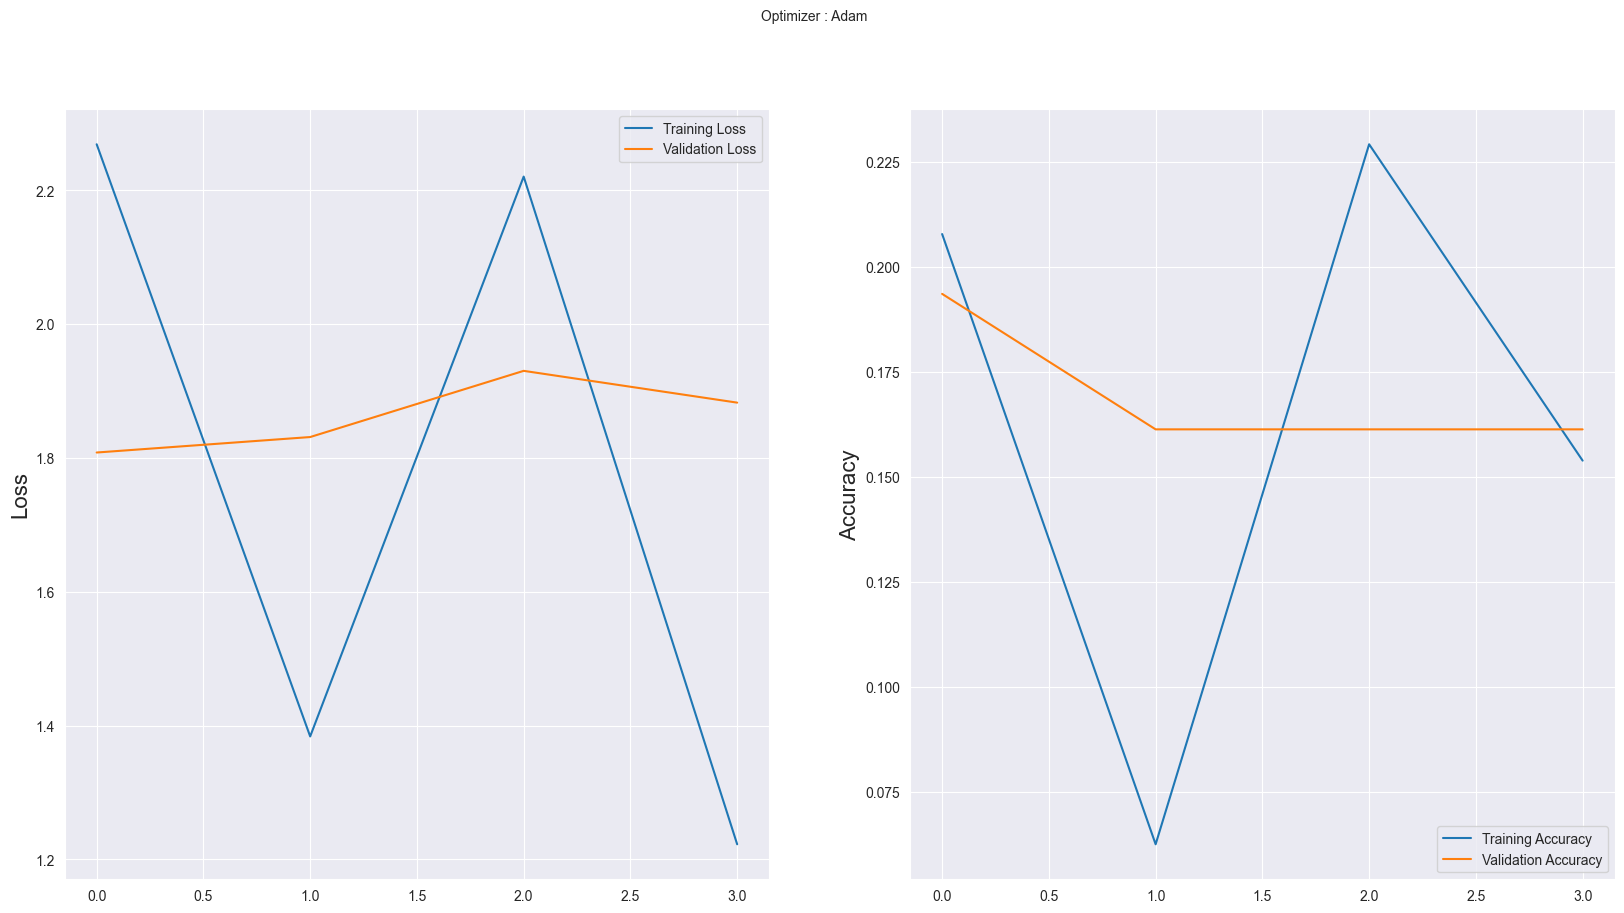

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()